# Классификация облаков

<b>Цель.</b> Неглубокие облака играют огромную роль в определении климата Земли, но их трудно распознать и классифицировать в климатических моделях. Классифицируя различные типы организации облаков, исследователи из Института Макса Планка надеются улучшить наше физическое понимание этих облаков, что, в свою очередь, поможет нам построить более совершенные климатические модели.
</br>Существует множество способов организации облаков, но границы между различными формами организации нечеткие. Это затрудняет построение традиционных алгоритмов, основанных на правилах, для разделения облачных характеристик. Однако человеческий глаз отлично справляется с обнаружением особенностей - например, облаков, похожих на цветы.
В этом задании вам предстоит построить модель для классификации моделей организации облаков на спутниковых снимках. В случае успеха вы поможете ученым лучше понять, как облака будут определять наш будущий климат.

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>
* сформировать нейронную сверточную сеть;
* обучить сеть на представленных данных;
* оценить качество модели. В качестве критерия используйте Dice coefficient.
* датасет для обучения модели: https://www.kaggle.com/competitions/understanding_cloud_organization/data

# Выполнение

Устанавливаем устройство (CPU или CUDA).

In [1]:
import torch
print (torch.cuda.is_available()) # Проверяем, доступно ли CUDA
print (torch.cuda.device_count()) # Выводим количество доступных GPU
print (torch.__version__) # Выводим версию PyTorch

True
1
2.3.0+cu118


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Импортируем основые библотеки.

In [3]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

Посмотрим на датасет.

In [4]:
train_csv_path = 'train.csv'
train_images_path = 'train_images/'

df = pd.read_csv(train_csv_path)
df['Image'] = df['Image_Label'].apply(lambda x: x.split('_')[0])
df['Label'] = df['Image_Label'].apply(lambda x: x.split('_')[1])

# Преобразуем DataFrame так, чтобы каждая строка соответствовала одному изображению
df = df.pivot(index='Image', columns='Label', values='EncodedPixels')
df = df.reset_index()

# Посмотрим на данные
df.head()

Label,Image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN
1,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...
2,0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...
3,0035239.jpg,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN
4,003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...


Реализуем функцию rle_decode, которая декодирует строку RLE-кодирования (Run-Length Encoding) в двумерный массив маски изображения.

In [5]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: строка RLE-кодирования
    shape: (ширина, высота) маски
    Возвращает: декодированная маска в виде numpy array
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

Определим класс CloudDataset, который наследуется от класса Dataset из библиотеки torch.utils.data. Класс предназначен для работы с набором данных изображений и их соответствующими масками, закодированными в формате RLE (Run-Length Encoding).
Инициализация класса "CloudDataset":
* init - метод инициализации, который вызывается при создании экземпляра класса.
* df - DataFrame, содержащий информацию об изображениях и соответствующих масках.
* img_dir - директория, в которой хранятся изображения.
* transform - необязательный параметр, определяющий трансформации для изображений и масок (например, аугментации данных).

Метод len:
* Возвращает количество изображений в наборе данных, что определяется длиной DataFrame self.df.

Метод getitem:
* getitem - метод, который возвращает изображение и соответствующие маски по индексу idx.
* img_name - имя изображения, извлекаемое из DataFrame.
* img_path - полный путь к изображению.
* image - изображение, загружаемое с диска и изменяемое до размера 256x256 пикселей.

Создание масок:
</br>1. Создаём пустой массив masks размером 256x256x4 для хранения масок для четырех классов объектов.
</br>2. Для каждого класса (Fish, Flower, Gravel, Sugar):
* Извлекается строка RLE-кодирования маски из DataFrame.
* Проверяется, является ли значение NaN, и заменяется на пустую строку, если это так.
* Если строка RLE-кодирования не пустая, она декодируется в маску с оригинальным размером 1400x2100 пикселей и затем изменяется до 256x256.

Применение трансформаций и преобразование в тензоры:
* Если задан параметр transform, применяются трансформации к изображению и маскам.
* Преобразуется изображение в тензор с помощью transforms.ToTensor().
* Преобразуется маски в тензор и изменяет их оси, чтобы привести к порядку [класс, высота, ширина].

Возвращение изображения и масок:
* Возвращается изображение и соответствующие маски в виде тензоров.

In [6]:
class CloudDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = imread(img_path)
        image = resize(image, (256, 256), mode='constant', preserve_range=True).astype(np.float32)  # Преобразование к float32
        
        masks = np.zeros((256, 256, 4), dtype=np.float32)
        for i, label in enumerate(['Fish', 'Flower', 'Gravel', 'Sugar']):
            mask_rle = self.df.iloc[idx][label]
            if pd.isna(mask_rle):  # Проверяем, является ли значение NaN
                mask_rle = ''  # Заменяем NaN на пустую строку
            
            if mask_rle:
                mask = rle_decode(mask_rle, (1400, 2100))
                mask = resize(mask, (256, 256), mode='constant', preserve_range=True).astype(np.float32)  # Преобразование к float32
                masks[..., i] = mask
        
        if self.transform:
            augmented = self.transform(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        image = transforms.ToTensor()(image)
        masks = torch.from_numpy(masks).permute(2, 0, 1)
        
        return image, masks

# Создаем датасет и разделяем на обучающую и тестовую выборки
dataset = CloudDataset(df, train_images_path, transform=None)
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Создадим объект набора данных (CloudDataset) и разделим его на обучающую и валидационную выборки, после чего создадим загрузчики данных (DataLoader) для каждой из выборок.

In [7]:
# Создаём датасет и разделяем на обучающую и тестовую выборки
dataset = CloudDataset(df, train_images_path, transform=None)
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Выполним проверку загрузки данных из train_loader, чтобы убедиться, что данные правильно загружаются и имеют правильные формы

In [8]:
import time

# Проверка загрузки данных
start_time = time.time()

for idx, (img, mask) in enumerate(train_loader):
    print(f"Batch {idx}, Image shape: {img.shape}, Mask shape: {mask.shape}")
    if idx == 1:  # Остановимся после первой проверки
        break

end_time = time.time()
print(f"Data loading test completed in {end_time - start_time:.2f} seconds")

Batch 0, Image shape: torch.Size([8, 3, 256, 256]), Mask shape: torch.Size([8, 4, 256, 256])
Batch 1, Image shape: torch.Size([8, 3, 256, 256]), Mask shape: torch.Size([8, 4, 256, 256])
Data loading test completed in 6.63 seconds


Определим архитектуру нейронной сети UNet для сегментации изображений. UNet состоит из симметричного энкодера и декодера, что позволяет модели хорошо захватывать и использовать как глобальные, так и локальные признаки изображения.

Определение класса UNet:
* class UNet(nn.Module) - определение класса UNet, который наследуется от nn.Module.
* self.encoder - используется ResNet34 в качестве энкодера для извлечения признаков из изображений.
* self.pool - операция макс-пулинга для уменьшения размерности признаков.

Определение блоков свёрток (конволюций) для энкодера:
* self.conv1 - первый блок свёрток для обработки входного изображения.
* nn.Conv2d - свертка с ядром 3x3.
* nn.ReLU - активационная функция ReLU.
* nn.Dropout - регуляризация для предотвращения переобучения.

Аналогично для других блоков энкодера.:
* self.conv2, self.conv3, self.conv4 - аналогичные блоки, но с увеличивающимся количеством каналов.

Определение транспонированных свёрток для декодера:
* self.upconv4, self.upconv3, self.upconv2 - транспонированные свёртки для увеличения размерности признаков.

Определение блоков свёрток для декодера:
* self.dec4, self.dec3, self.dec2 - блоки свёрток для обработки признаков после объединения (конкатенации) с признаками из энкодера.

Определение финального слоя:
* self.final - последний свёрточный слой, который уменьшает количество каналов до 4 (по одному для каждой маски сегментации).

Определение метода forward:
* Метод forward определяет, как данные проходят через сеть.
* Encoder: e1, e2, e3, e4 - этапы энкодера, применяющие последовательные свёртки и пулинги к входному изображению.
* Decoder: d4, d3, d2 - этапы декодера, которые применяют транспонированные свёртки и конкатенируют признаки с соответствующими признаками из энкодера.
* Decoder: torch.cat((d4, e3), dim=1) - объединение (конкатенация) признаков по каналам.
* Output: out - финальный выход сети, который представляет собой 4-классовую маску сегментации.
















In [9]:
# Определение модели
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.upconv4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.dec4 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.final = nn.Conv2d(64, 4, 1)

    def forward(self, x):
        # Encoder
        e1 = self.conv1(x)
        e2 = self.conv2(self.pool(e1))
        e3 = self.conv3(self.pool(e2))
        e4 = self.conv4(self.pool(e3))

        # Decoder
        d4 = self.upconv4(e4)
        d4 = torch.cat((d4, e3), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e2), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e1), dim=1)
        d2 = self.dec2(d2)

        out = self.final(d2)

        return out

In [10]:
print(f'Количество батчей в train_loader: {len(train_loader)}')

Количество батчей в train_loader: 555


Реализуем процесс обучения и оценки модели UNet для задачи сегментации изображений.

Определение устройства для вычислений:
* Устанавливаем устройство для выполнения вычислений. Если доступен GPU, используется 'cuda', иначе используется CPU.

Инициализация модели, функции потерь и оптимизатора:
* Создаём экземпляр модели UNet и перемещает её на выбранное устройство.
* criterion - функция потерь. Здесь используется BCEWithLogitsLoss, подходящая для многоклассовой сегментации.
* optimizer - оптимизатор Adam с параметрами lr (learning rate) и weight_decay (параметр для регуляризации).

Гиперпараметры и инициализация списков для хранения значений потерь:
* num_epochs - количество эпох обучения.
* train_losses и val_losses - списки для хранения значений потерь на обучающей и валидационной выборках для каждой эпохи.

Основной цикл обучения:
* for epoch in range(num_epochs): цикл по количеству эпох.
* model.train(): перевод модели в режим обучения.
* for images, masks in train_loader: итерация по батчам данных из обучающего набора.
* images и masks.to(device): перемещение данных на устройство (CPU или GPU).
* optimizer.zero_grad(): обнуление градиентов.
* outputs = model(images): прямое распространение (forward pass) через модель.
* loss = criterion(outputs, masks): вычисление функции потерь.
* loss.backward(): обратное распространение (backward pass) для вычисления градиентов.
* optimizer.step(): обновление параметров модели.
* running_loss += loss.item() * images.size(0): накопление значения потерь для текущего батча.
* epoch_loss = running_loss / len(train_loader.dataset): вычисление средней потери за эпоху.
* train_losses.append(epoch_loss): сохранение значения потерь для обучающей выборки.

Оценка модели на валидационной выборке:
* model.eval(): перевод модели в режим оценки (отключение dropout и batch normalization).
* with torch.no_grad(): отключение вычисления градиентов для уменьшения потребления памяти и ускорения вычислений.
* for images, masks in val_loader: итерация по батчам данных из валидационного набора.
* outputs = model(images): прямое распространение (forward pass) через модель.
* loss = criterion(outputs, masks): вычисление функции потерь.
* val_loss += loss.item() * images.size(0): накопление значения потерь для текущего батча.
* val_loss = val_loss / len(val_loader.dataset): вычисление средней потери за эпоху.
* val_losses.append(val_loss): сохранение значения потерь для валидационной выборки.
* print(...): вывод информации о текущей эпохе, включая потери на обучающей и валидационной выборках.

In [11]:
# Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 25

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Оценка на валидационной выборке
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/25, Train Loss: 0.4472, Validation Loss: 0.4155
Epoch 2/25, Train Loss: 0.4265, Validation Loss: 0.4169
Epoch 3/25, Train Loss: 0.4207, Validation Loss: 0.4126
Epoch 4/25, Train Loss: 0.4175, Validation Loss: 0.4125
Epoch 5/25, Train Loss: 0.4145, Validation Loss: 0.4137
Epoch 6/25, Train Loss: 0.4127, Validation Loss: 0.4111
Epoch 7/25, Train Loss: 0.4096, Validation Loss: 0.4013
Epoch 8/25, Train Loss: 0.4021, Validation Loss: 0.3956
Epoch 9/25, Train Loss: 0.3941, Validation Loss: 0.3858
Epoch 10/25, Train Loss: 0.3911, Validation Loss: 0.3884
Epoch 11/25, Train Loss: 0.3895, Validation Loss: 0.3873
Epoch 12/25, Train Loss: 0.3869, Validation Loss: 0.3814
Epoch 13/25, Train Loss: 0.3862, Validation Loss: 0.3851
Epoch 14/25, Train Loss: 0.3835, Validation Loss: 0.3839
Epoch 15/25, Train Loss: 0.3820, Validation Loss: 0.3840
Epoch 16/25, Train Loss: 0.3817, Validation Loss: 0.3765
Epoch 17/25, Train Loss: 0.3814, Validation Loss: 0.3788
Epoch 18/25, Train Loss: 0.3795, Validat

Построим график потерь на обучающей и валидационной выборках в течение обучения модели.

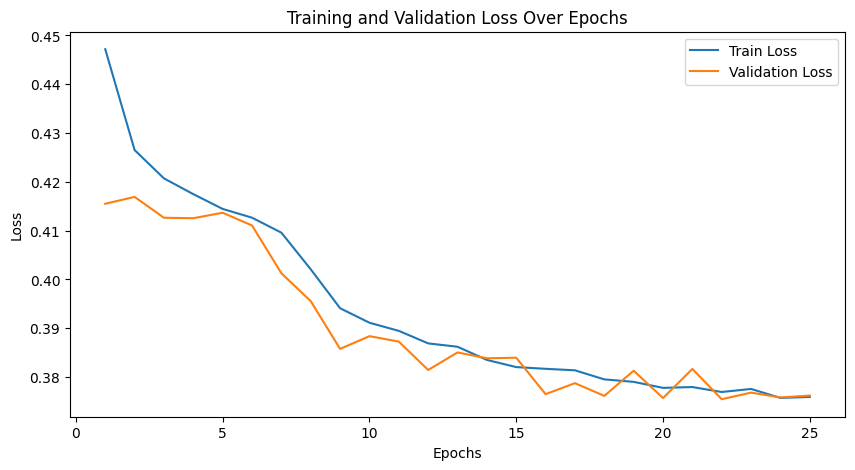

In [52]:
# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()